fastText是Facebook于2016年开源的一个词向量计算和文本分类工具，在学术上并没有太大创新。但是它的优点也非常明显，在文本分类任务中，fastText（浅层网络）往往能取得和深度网络相媲美的精度，却在训练时间上比深度网络快许多数量级。在标准的多核CPU上， 能够训练10亿词级别语料库的词向量在10分钟之内，能够分类有着30万多类别的50多万句子在1分钟之内。


本文首先会介绍一些预备知识，比如ngram等，然后简单介绍word2vec原理，之后来讲解fastText的原理，并着手使用keras搭建一个简单的fastText分类器，最后，我们会介绍fastText在达观数据的应用。

**1.n-gram特征**

在文本特征提取中，常常能看到n-gram的身影。它是一种基于语言模型的算法，基本思想是将文本内容按照字节顺序进行大小为N的滑动窗口操作，最终形成长度为N的字节片段序列。看下面的例子：

我来到达观数据参观

相应的bigram特征为：我来 来到 到达 达观 观数 数据 据参 参观

相应的trigram特征为：我来到 来到达 到达观 达观数 观数据 数据参 据参观



注意一点：n-gram中的gram根据粒度不同，有不同的含义。它可以是字粒度，也可以是词粒度的。上面所举的例子属于字粒度的n-gram，词粒度的n-gram看下面例子：

我 来到 达观数据 参观

相应的bigram特征为：我/来到 来到/达观数据 达观数据/参观

相应的trigram特征为：我/来到/达观数据 来到/达观数据/参观


n-gram产生的特征只是作为文本特征的候选集，你后面可能会采用信息熵、卡方统计、IDF等文本特征选择方式筛选出比较重要特征。



** 2.word2vec**

（1）模型架构
CBOW模型的基本思路是：用上下文预测目标词汇。架构图如下所示：

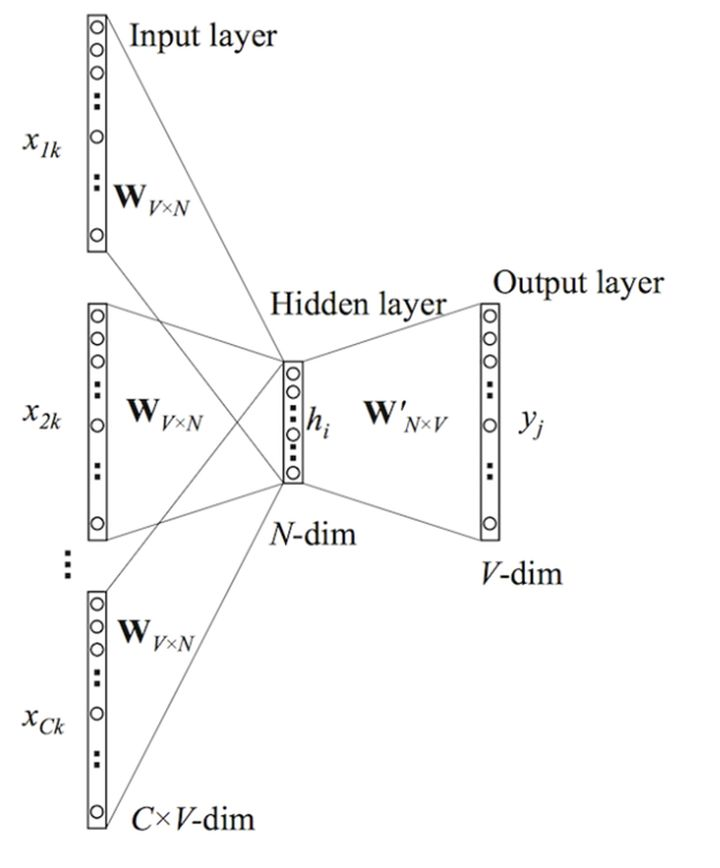

（2）前向传播
输入是如何计算而获得输出呢？先假设我们已经获得了权重矩阵 W 和 W' （具体的推导见第3节），隐含层h的输出的计算公式：

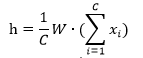

即：隐含层的输出是C个上下文单词向量的加权平均，权重为W。

接着我们计算输出层的每个节点：

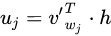

（3）反向传播学习权重矩阵
在学习权重矩阵和过程中，我们首先随机产生初始值，然后feed训练样本到我们的模型，并观测我们期望输出和真实输出的误差。接着，我们计算误差关于权重矩阵的梯度，并在梯度的方向纠正它们。



首先定义损失函数，objective是最大化给定输入上下文，target单词的条件概率。因此，损失函数为：

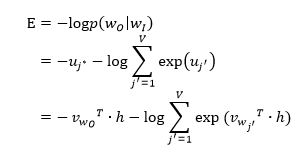

#  fastText分类

1）字符级别的n-gram
word2vec把语料库中的每个单词当成原子的，它会为每个单词生成一个向量。这忽略了单词内部的形态特征，比如：“apple” 和“apples”，“达观数据”和“达观”，这两个例子中，两个单词都有较多公共字符，即它们的内部形态类似，但是在传统的word2vec中，这种单词内部形态信息因为它们被转换成不同的id丢失了。

为了克服这个问题，fastText使用了字符级别的n-grams来表示一个单词。对于单词“apple”，假设n的取值为3，则它的trigram有



“<ap”, “app”, “ppl”, “ple”, “le>”



其中，<表示前缀，>表示后缀。于是，我们可以用这些trigram来表示“apple”这个单词，进一步，我们可以用这5个trigram的向量叠加来表示“apple”的词向量。
这带来两点好处：

1. 对于低频词生成的词向量效果会更好。因为它们的n-gram可以和其它词共享。

2. 对于训练词库之外的单词，仍然可以构建它们的词向量。我们可以叠加它们的字符级n-gram向量。



（2）模型架构
之前提到过，fastText模型架构和word2vec的CBOW模型架构非常相似。下面是fastText模型架构图：



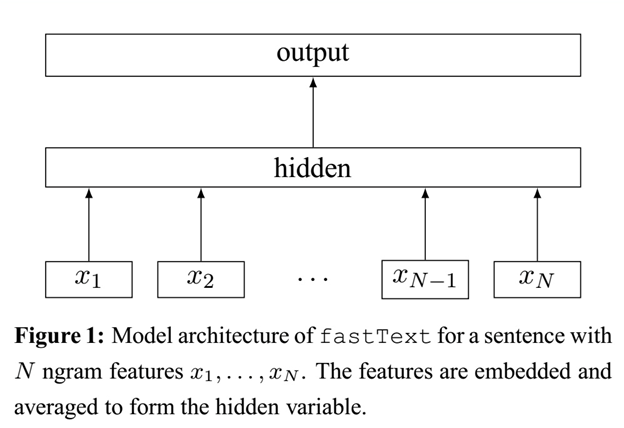

注意：此架构图没有展示词向量的训练过程。可以看到，和CBOW一样，fastText模型也只有三层：输入层、隐含层、输出层（Hierarchical Softmax），输入都是多个经向量表示的单词，输出都是一个特定的target，隐含层都是对多个词向量的叠加平均。不同的是，CBOW的输入是目标单词的上下文，fastText的输入是多个单词及其n-gram特征，这些特征用来表示单个文档；CBOW的输入单词被onehot编码过，fastText的输入特征是被embedding过；CBOW的输出是目标词汇，fastText的输出是文档对应的类标。



值得注意的是，fastText在输入时，将单词的字符级别的n-gram向量作为额外的特征；在输出时，fastText采用了分层Softmax，大大降低了模型训练时间。这两个知识点在前文中已经讲过，这里不再赘述。

（3）核心思想
现在抛开那些不是很讨人喜欢的公式推导，来想一想fastText文本分类的核心思想是什么？



仔细观察模型的后半部分，即从隐含层输出到输出层输出，会发现它就是一个softmax线性多类别分类器，分类器的输入是一个用来表征当前文档的向量；模型的前半部分，即从输入层输入到隐含层输出部分，主要在做一件事情：生成用来表征文档的向量。那么它是如何做的呢？叠加构成这篇文档的所有词及n-gram的词向量，然后取平均。叠加词向量背后的思想就是传统的词袋法，即将文档看成一个由词构成的集合。



于是fastText的核心思想就是：将整篇文档的词及n-gram向量叠加平均得到文档向量，然后使用文档向量做softmax多分类。这中间涉及到两个技巧：字符级n-gram特征的引入以及分层Softmax分类。



（4）关于分类效果
还有个问题，就是为何fastText的分类效果常常不输于传统的非线性分类器？



假设我们有两段文本：



我 来到 达观数据

俺 去了 达而观信息科技



这两段文本意思几乎一模一样，如果要分类，肯定要分到同一个类中去。但在传统的分类器中，用来表征这两段文本的向量可能差距非常大。传统的文本分类中，你需要计算出每个词的权重，比如tfidf值， “我”和“俺” 算出的tfidf值相差可能会比较大，其它词类似，于是，VSM（向量空间模型）中用来表征这两段文本的文本向量差别可能比较大。但是fastText就不一样了，它是用单词的embedding叠加获得的文档向量，词向量的重要特点就是向量的距离可以用来衡量单词间的语义相似程度，于是，在fastText模型中，这两段文本的向量应该是非常相似的，于是，它们很大概率会被分到同一个类中。



使用词embedding而非词本身作为特征，这是fastText效果好的一个原因；另一个原因就是字符级n-gram特征的引入对分类效果会有一些提升 。

# 手写一个fastText

keras是一个抽象层次很高的神经网络API，由python编写，底层可以基于Tensorflow、Theano或者CNTK。它的优点在于：用户友好、模块性好、易扩展等。所以下面我会用keras简单搭一个fastText的demo版。

为了简化我们的任务：

1. 训练词向量时，我们使用正常的word2vec方法，而真实的fastText还附加了字符级别的n-gram作为特征输入；

2. 我们的输出层使用简单的softmax分类，而真实的fastText使用的是Hierarchical Softmax。



首先定义几个常量：



VOCAB_SIZE = 2000

EMBEDDING_DIM =100

MAX_WORDS = 500

CLASS_NUM = 5



VOCAB_SIZE表示词汇表大小，这里简单设置为2000；

EMBEDDING_DIM表示经过embedding层输出，每个词被分布式表示的向量的维度，这里设置为100。比如对于“达观”这个词，会被一个长度为100的类似于[ 0.97860014, 5.93589592, 0.22342691, -3.83102846, -0.23053935, …]的实值向量来表示；

MAX_WORDS表示一篇文档最多使用的词个数，因为文档可能长短不一（即词数不同），为了能feed到一个固定维度的神经网络，我们需要设置一个最大词数，对于词数少于这个阈值的文档，我们需要用“未知词”去填充。比如可以设置词汇表中索引为0的词为“未知词”，用0去填充少于阈值的部分；

CLASS_NUM表示类别数，多分类问题，这里简单设置为5。



模型搭建遵循以下步骤：

1. 添加输入层（embedding层）。Embedding层的输入是一批文档，每个文档由一个词汇索引序列构成。例如：[10, 30, 80, 1000] 可能表示“我 昨天 来到 达观数据”这个短文本，其中“我”、“昨天”、“来到”、“达观数据”在词汇表中的索引分别是10、30、80、1000；Embedding层将每个单词映射成EMBEDDING_DIM维的向量。于是：input_shape=(BATCH_SIZE, MAX_WORDS), output_shape=(BATCH_SIZE,
MAX_WORDS, EMBEDDING_DIM)；

2. 添加隐含层（投影层）。投影层对一个文档中所有单词的向量进行叠加平均。keras提供的GlobalAveragePooling1D类可以帮我们实现这个功能。这层的input_shape是Embedding层的output_shape，这层的output_shape=( BATCH_SIZE, EMBEDDING_DIM)；

3. 添加输出层（softmax层）。真实的fastText这层是Hierarchical Softmax，因为keras原生并没有支持Hierarchical Softmax，所以这里用Softmax代替。这层指定了CLASS_NUM，对于一篇文档，输出层会产生CLASS_NUM个概率值，分别表示此文档属于当前类的可能性。这层的output_shape=(BATCH_SIZE, CLASS_NUM)

4. 指定损失函数、优化器类型、评价指标，编译模型。损失函数我们设置为categorical_crossentropy，它就是我们上面所说的softmax回归的损失函数；优化器我们设置为SGD，表示随机梯度下降优化器；评价指标选择accuracy，表示精度。



用训练数据feed模型时，你需要：

1. 将文档分好词，构建词汇表。词汇表中每个词用一个整数（索引）来代替，并预留“未知词”索引，假设为0；

2. 对类标进行onehot化。假设我们文本数据总共有3个类别，对应的类标分别是1、2、3，那么这三个类标对应的onehot向量分别是[1, 0,
0]、[0, 1, 0]、[0, 0, 1]；

3. 对一批文本，将每个文本转化为词索引序列，每个类标转化为onehot向量。就像之前的例子，“我 昨天 来到 达观数据”可能被转化为[10, 30,
80, 1000]；它属于类别1，它的类标就是[1, 0, 0]。由于我们设置了MAX_WORDS=500，这个短文本向量后面就需要补496个0，即[10, 30, 80, 1000, 0, 0, 0, …, 0]。因此，batch_xs的 维度为( BATCH_SIZE,MAX_WORDS)，batch_ys的维度为（BATCH_SIZE, CLASS_NUM）。



下面是构建模型的代码，数据处理、feed数据到模型的代码比较繁琐，这里不展示。

In [ ]:
from __future__ import unicode_literals
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.layers import Dense

VOCAB_SIZE = 2000
EMBEDDING_DIM = 100
MAX_WORDS = 500
CLASS_NUM = 5

def build_fastText():
    model = Sequential()
    #通过embedding层，我们将词汇映射成EMBEDDING_DIM维向量
    model.add(Embedding(VOCAB_SIZE,EMBEDDING_DIM,input_length=MAX_WORDS))
    #通过GlobalAveragePooling1D，我们平均了文档中所有词的embedding
    model.add( GlobalAveragePooling1D())
    #通过输出层Softmax分类（真实的fastText这里是分层Softmax),得到类别概率分类
    model.add(Dense(CLASS_NUM,activation='softmax'))
    #定义损失函数，优化器，分类度量指标
    model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
    return model

if __name__ == '__main__':
    model = build_fastText()
    print(model.summary())
